Step 3:
Use the transformed predictors in the training set to learn either a PLS or a PCR
regression model and test the model using the test set (remember to apply the
same pre-processing you used on the training set). Determine the optimal number
of components using a 5- or 10-fold cross-validation based on the RMSE (you can
only use the training set in this phase). Report on process (show the cross-validation
profile, both in terms of the RMSE and R2 ). Report the accuracy (RMSE and R2 )
obtained on the test set.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression


RED WHINE

In [22]:
df_red = pd.read_csv("../dataset/winequality-red.csv", sep=';',index_col=False)
df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [23]:

def k_fold_pcr(X, y, k, n_components):
    np.random.seed(42)
    
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if hasattr(y, "to_numpy"):
        y = y.to_numpy()

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    new_X = X[indices]
    new_y = y[indices]

    fold_size = len(X) // k
    folds_X = []
    folds_y = []
    rmse_list = []
    r2_list = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds_X.append(new_X[start:end])
        folds_y.append(new_y[start:end])

    for i in range(k):
        X_val = folds_X[i]
        y_val = folds_y[i]

        X_train_fold = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train_fold = np.hstack([folds_y[j] for j in range(k) if j != i])

        X_train_mean = X_train_fold.mean(axis=0)
        X_train_std = X_train_fold.std(axis=0)
        X_train_std[X_train_std == 0] = 1
        
        X_train_fold_scaled = (X_train_fold - X_train_mean) / X_train_std
        X_val_scaled = (X_val - X_train_mean) / X_train_std

        cov_train = np.cov(X_train_fold_scaled, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_train)
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        V = eigenvectors[:, :n_components]
        
        X_train_pca = X_train_fold_scaled @ V
        X_val_pca = X_val_scaled @ V

        X_train_adjusted = np.hstack([np.ones((X_train_pca.shape[0], 1)), X_train_pca])
        X_val_adjusted = np.hstack([np.ones((X_val_pca.shape[0], 1)), X_val_pca])

        beta_i = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train_fold
        y_pred_val = X_val_adjusted @ beta_i
        
        rmse_fold = np.sqrt(np.mean((y_val - y_pred_val)**2))
        ss_res = np.sum((y_val - y_pred_val)**2)
        ss_tot = np.sum((y_val - y_val.mean())**2)
        r2_fold = 1 - (ss_res / ss_tot)

        rmse_list.append(rmse_fold)
        r2_list.append(r2_fold)
        
    return rmse_list, r2_list, np.mean(rmse_list), np.std(rmse_list), np.mean(r2_list), np.std(r2_list)


In [46]:
def print_builtin_results(name, rmse_scores, r2_scores):
    print(f"\n====== {name} (BUILT-IN) ======")
    print(f"RMSE per fold: {['{:.17f}'.format(x) for x in rmse_scores]}")
    print(f"R² per fold  : {['{:.17f}'.format(x) for x in r2_scores]}")
    print(f"\nRMSE Mean ± Std: {rmse_scores.mean():.17f} ± {rmse_scores.std():.17f}")
    print(f"R²   Mean ± Std: {r2_scores.mean():.17f} ± {r2_scores.std():.17f}")
    print("=========================\n")

def print_cv_results(name, results):
    print(f"\n====== {name} ======")
    print(f"RMSE per fold: {['{:.17f}'.format(x) for x in results[0]]}")
    print(f"R² per fold  : {['{:.17f}'.format(x) for x in results[1]]}")
    print(f"\nRMSE Mean ± Std: {results[2]:.17f} ± {results[3]:.17f}")
    print(f"R²   Mean ± Std: {results[4]:.17f} ± {results[5]:.17f}")
    print("=========================\n")

#PCR

In [25]:

X_red = df_red.drop(['quality'], axis=1)
y_red = df_red['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

RMSE_per_component_5fold = []
RMSE_per_component_10fold=[]
R2_per_component_5fold = []
R2_per_component_10fold=[]
RMSE_test_per_component = []
R2_test_per_component = []

# Preprocess training and test sets once
X_train_mean = X_train_red.mean(axis=0)
X_train_std = X_train_red.std(axis=0)
X_train_std[X_train_std == 0] = 1

X_train_scaled = (X_train_red - X_train_mean) / X_train_std
X_test_scaled = (X_test_red - X_train_mean) / X_train_std

cov_train = np.cov(X_train_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_train)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

for i in range(2,12):
    print("\nNumber of Principal Components:", i)
    k_fold_results_5 = k_fold_pcr(X_train_red, y_train_red, k=5, n_components=i)
    k_fold_results_10 = k_fold_pcr(X_train_red, y_train_red, k=10, n_components=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold.append(k_fold_results_5[2])
    R2_per_component_5fold.append(k_fold_results_5[4])
    RMSE_per_component_10fold.append(k_fold_results_10[2])
    R2_per_component_10fold.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    V = eigenvectors[:, :i]
    X_train_pca = X_train_scaled @ V
    X_test_pca = X_test_scaled @ V
    
    X_train_adjusted = np.hstack([np.ones((X_train_pca.shape[0], 1)), X_train_pca])
    X_test_adjusted = np.hstack([np.ones((X_test_pca.shape[0], 1)), X_test_pca])
    
    beta = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train_red
    y_test_pred = X_test_adjusted @ beta
    
    test_rmse = np.sqrt(np.mean((y_test_red - y_test_pred)**2))
    ss_res_test = np.sum((y_test_red - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_red - y_test_red.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component.append(test_rmse)
    R2_test_per_component.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold[optimal_5fold_idx]:.4f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold[optimal_10fold_idx]:.4f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component[optimal_5fold_idx]:.4f}")
print(f"Test Set R²: {R2_test_per_component[optimal_5fold_idx]:.4f}")
print("="*60)





Number of Principal Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7156', '0.7204', '0.7478', '0.7476', '0.7405']
R² per fold  : ['0.1125', '0.1857', '0.1818', '0.1841', '0.1502']

RMSE Mean ± Std: 0.7344 ± 0.0137
R²   Mean ± Std: 0.1629 ± 0.0284


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7249', '0.7065', '0.7585', '0.6772', '0.7677', '0.7333', '0.7697', '0.7277', '0.7941', '0.6847']
R² per fold  : ['0.1066', '0.1164', '0.2001', '0.1732', '0.1608', '0.1954', '0.1492', '0.2191', '0.0735', '0.2144']

RMSE Mean ± Std: 0.7344 ± 0.0363
R²   Mean ± Std: 0.1609 ± 0.0467


Number of Principal Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.6683', '0.6626', '0.6949', '0.6677', '0.6766']
R² per fold  : ['0.2260', '0.3112', '0.2934', '0.3491', '0.2904']

RMSE Mean ± Std: 0.6740 ± 0.0114
R²   Mean ± Std: 0.2940 ± 0.0399


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.6703', '0.6680', '0.6837', '0.6438', '0.6813', '0.698

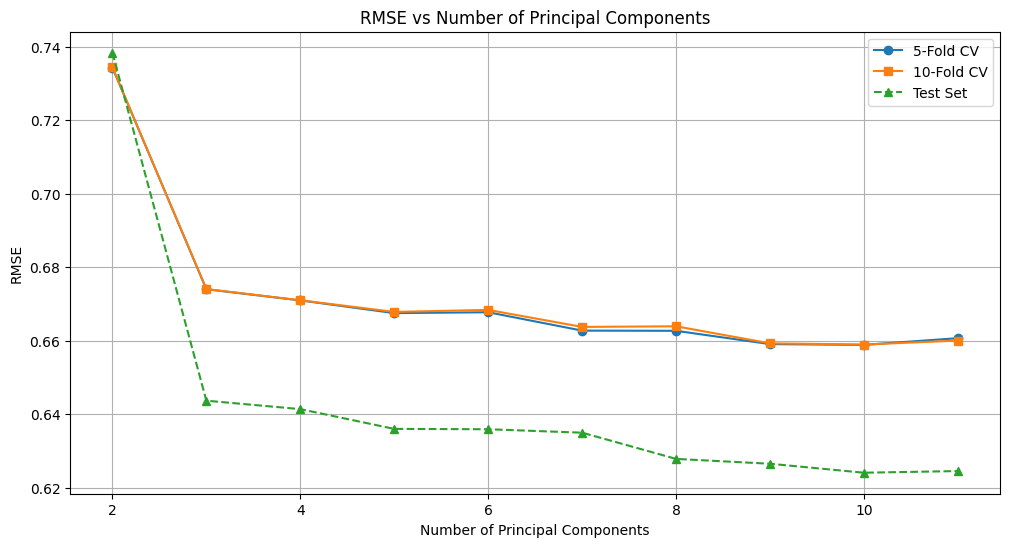

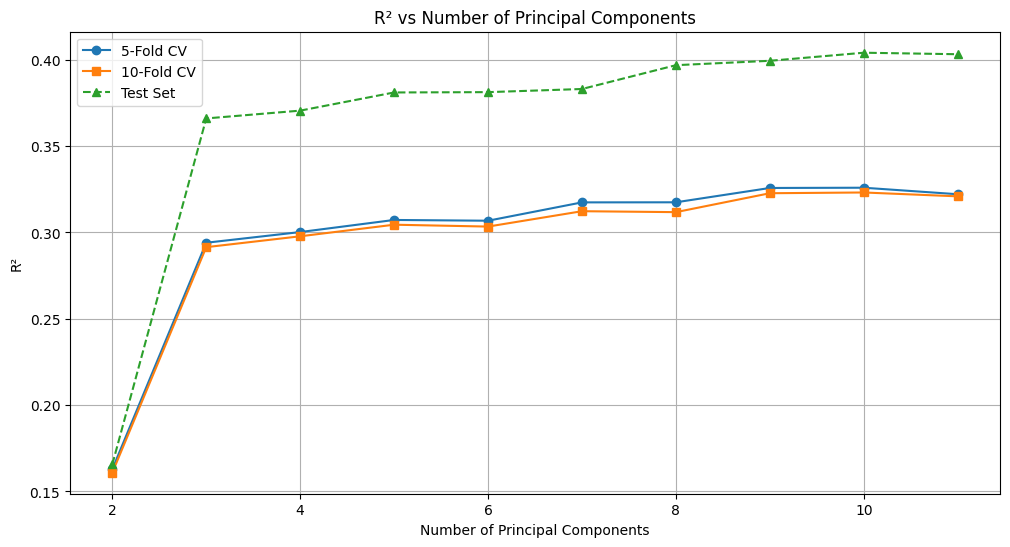

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component, marker='^', label='Test Set', linestyle='--')
plt.title('RMSE vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component, marker='^', label='Test Set', linestyle='--')
plt.title('R² vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()

WHITE WINE

In [27]:
df_white = pd.read_csv("../dataset/winequality-white.csv", sep=';',index_col=False)
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [28]:

X_white = df_white.drop(['quality'], axis=1)
y_white = df_white['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=42)

RMSE_per_component_5fold = []
RMSE_per_component_10fold=[]
R2_per_component_5fold = []
R2_per_component_10fold=[]
RMSE_test_per_component = []
R2_test_per_component = []

# Preprocess training and test sets once
X_train_mean = X_train_white.mean(axis=0)
X_train_std = X_train_white.std(axis=0)
X_train_std[X_train_std == 0] = 1

X_train_scaled = (X_train_white - X_train_mean) / X_train_std
X_test_scaled = (X_test_white - X_train_mean) / X_train_std

cov_train = np.cov(X_train_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_train)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

for i in range(2,12):
    print("\nNumber of Principal Components:", i)
    k_fold_results_5 = k_fold_pcr(X_train_white, y_train_white, k=5, n_components=i)
    k_fold_results_10 = k_fold_pcr(X_train_white, y_train_white, k=10, n_components=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold.append(k_fold_results_5[2])
    R2_per_component_5fold.append(k_fold_results_5[4])
    RMSE_per_component_10fold.append(k_fold_results_10[2])
    R2_per_component_10fold.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    V = eigenvectors[:, :i]
    X_train_pca = X_train_scaled @ V
    X_test_pca = X_test_scaled @ V
    
    X_train_adjusted = np.hstack([np.ones((X_train_pca.shape[0], 1)), X_train_pca])
    X_test_adjusted = np.hstack([np.ones((X_test_pca.shape[0], 1)), X_test_pca])
    
    beta = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train_white
    y_test_pred = X_test_adjusted @ beta
    
    test_rmse = np.sqrt(np.mean((y_test_white - y_test_pred)**2))
    ss_res_test = np.sum((y_test_white - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_white - y_test_white.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component.append(test_rmse)
    R2_test_per_component.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold[optimal_5fold_idx]:.4f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold[optimal_10fold_idx]:.4f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component[optimal_5fold_idx]:.4f}")
print(f"Test Set R²: {R2_test_per_component[optimal_5fold_idx]:.4f}")
print("="*60)



Number of Principal Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8445', '0.8397', '0.8292', '0.8796', '0.8514']
R² per fold  : ['0.0788', '0.0462', '0.0952', '0.0650', '0.1212']

RMSE Mean ± Std: 0.8489 ± 0.0170
R²   Mean ± Std: 0.0813 ± 0.0256


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8214', '0.8653', '0.8090', '0.8653', '0.8151', '0.8435', '0.8425', '0.9136', '0.8502', '0.8516']
R² per fold  : ['0.0861', '0.0744', '0.0705', '0.0325', '0.0886', '0.1080', '0.0877', '0.0443', '0.1121', '0.1293']

RMSE Mean ± Std: 0.8478 ± 0.0288
R²   Mean ± Std: 0.0833 ± 0.0282


Number of Principal Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8364', '0.8111', '0.8037', '0.8516', '0.8175']
R² per fold  : ['0.0964', '0.1101', '0.1500', '0.1236', '0.1898']

RMSE Mean ± Std: 0.8240 ± 0.0176
R²   Mean ± Std: 0.1340 ± 0.0330


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.8104', '0.8545', '0.7872', '0.8264', '0.7830', '0.824

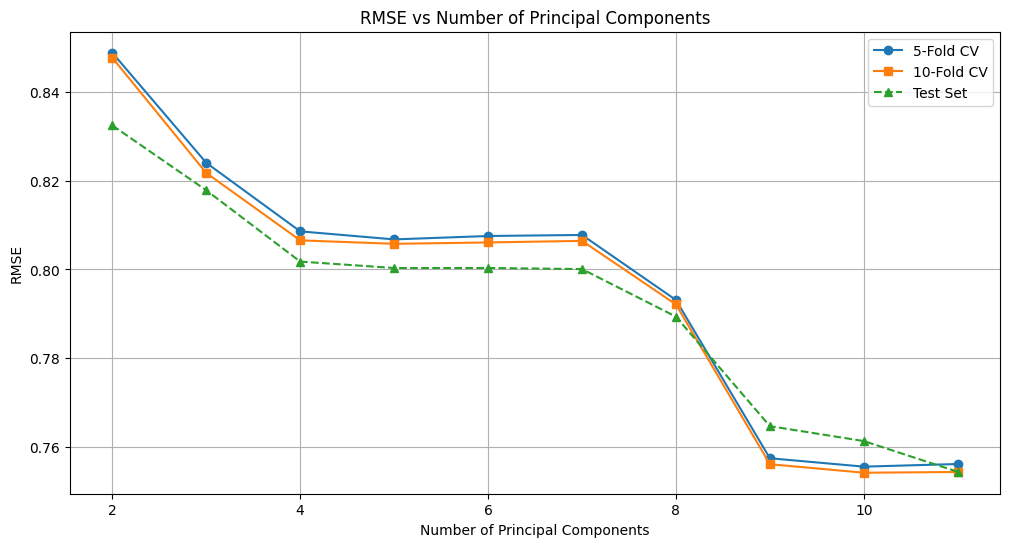

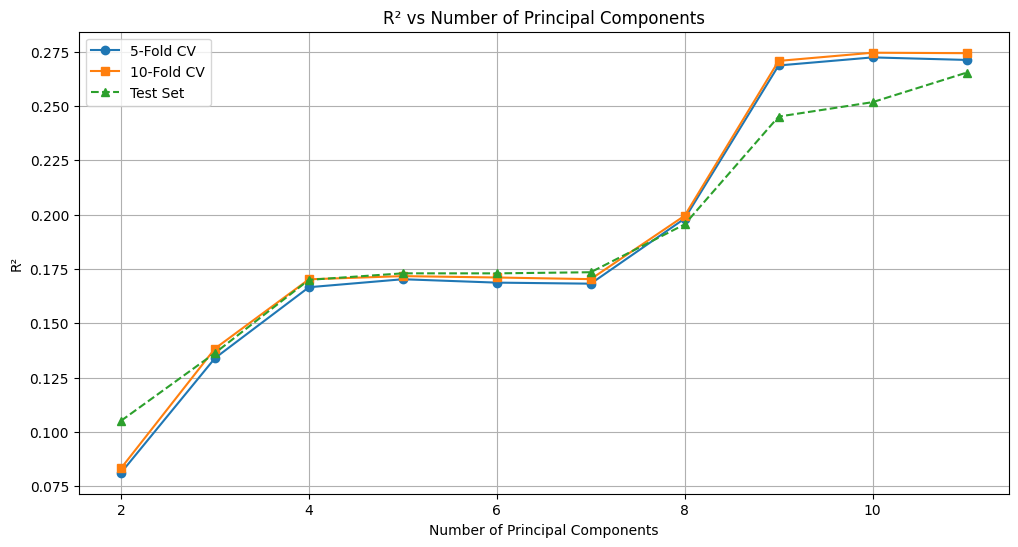

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component, marker='^', label='Test Set', linestyle='--')
plt.title('RMSE vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()  

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component, marker='^', label='Test Set', linestyle='--')
plt.title('R² vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()

PLS

In [30]:
def fit_pls_manual(X, y, n_components):
    if hasattr(X, "to_numpy"): X = X.to_numpy()
    if hasattr(y, "to_numpy"): y = y.to_numpy()

    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_std[X_std == 0] = 1
    X_k = (X - X_mean) / X_std
    
    y_mean = y.mean()
    y_k = y - y_mean
  
    weights = []
    coeffs = []
    loadings = []
    
    for m in range(n_components):
        phi = np.dot(X_k.T, y_k)
        z = np.dot(X_k, phi)
        z_norm = np.dot(z.T, z)
        if z_norm < 1e-10:
            break
            
        theta = np.dot(z.T, y_k) / z_norm
        p = np.dot(z.T, X_k) / z_norm
        
        X_k = X_k - np.outer(z, p)
        y_k = y_k - z * theta
        
        weights.append(phi)
        coeffs.append(theta)
        loadings.append(p)
        
    return {
        'weights': weights,
        'coeffs': coeffs,
        'loadings': loadings,
        'X_mean': X_mean,
        'X_std': X_std,
        'y_mean': y_mean
    }

In [31]:
def predict_pls_manual(model, X_test):
    if hasattr(X_test, "to_numpy"): X_test = X_test.to_numpy()
    
    X_k = (X_test - model['X_mean']) / model['X_std']
    n_samples = X_test.shape[0]
    y_pred = np.zeros(n_samples)
    
    for m in range(len(model['weights'])):
        phi = model['weights'][m]
        theta = model['coeffs'][m]
        p = model['loadings'][m]
        
        z = np.dot(X_k, phi)
        y_pred += z * theta
        X_k = X_k - np.outer(z, p)
        
    return y_pred + model['y_mean']

In [32]:
def k_fold_pls(X, y, k, n_comp):
    np.random.seed(42)
    
    if hasattr(X, "to_numpy"): X = X.to_numpy()
    if hasattr(y, "to_numpy"): y = y.to_numpy()

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    new_X = X[indices]
    new_y = y[indices]

    fold_size = len(X) // k
    folds_X = []
    folds_y = []
    rmse_list = []
    r2_list = []
    
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size
        folds_X.append(new_X[start:end])
        folds_y.append(new_y[start:end])

    for i in range(k):
        X_val = folds_X[i]
        y_val = folds_y[i]

        X_train = np.vstack([folds_X[j] for j in range(k) if j != i])
        y_train = np.hstack([folds_y[j] for j in range(k) if j != i])

        model = fit_pls_manual(X_train, y_train, n_components=n_comp)
        y_pred_val = predict_pls_manual(model, X_val)

        rmse_fold = np.sqrt(np.mean((y_val - y_pred_val)**2))
        ss_res = np.sum((y_val - y_pred_val)**2)
        ss_tot = np.sum((y_val - y_val.mean())**2)
        r2_fold = 1 - (ss_res / ss_tot)

        rmse_list.append(rmse_fold)
        r2_list.append(r2_fold)
        
    rmse_list = np.array(rmse_list)
    r2_list = np.array(r2_list)
    
    return rmse_list, r2_list, np.mean(rmse_list), np.std(rmse_list), np.mean(r2_list), np.std(r2_list)

################################################
##### PLS - RED WINE (Implementação Manual) #####
################################################

Number of PLS Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.6563', '0.6450', '0.6804', '0.6539', '0.6683']
R² per fold  : ['0.2535', '0.3474', '0.3225', '0.3758', '0.3078']

RMSE Mean ± Std: 0.6608 ± 0.0123
R²   Mean ± Std: 0.3214 ± 0.0411


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.6450', '0.6685', '0.6693', '0.6248', '0.6646', '0.6920', '0.6808', '0.6348', '0.7217', '0.6132']
R² per fold  : ['0.2927', '0.2089', '0.3771', '0.2961', '0.3709', '0.2835', '0.3344', '0.4056', '0.2348', '0.3700']

RMSE Mean ± Std: 0.6615 ± 0.0312
R²   Mean ± Std: 0.3174 ± 0.0617


Number of PLS Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.6517', '0.6442', '0.6830', '0.6566', '0.6616']
R² per fold  : ['0.2639', '0.3488', '0.3173', '0.3705', '0.3216']

RMSE Mean ± Std: 0.6594 ± 0.0131
R²   Mean 

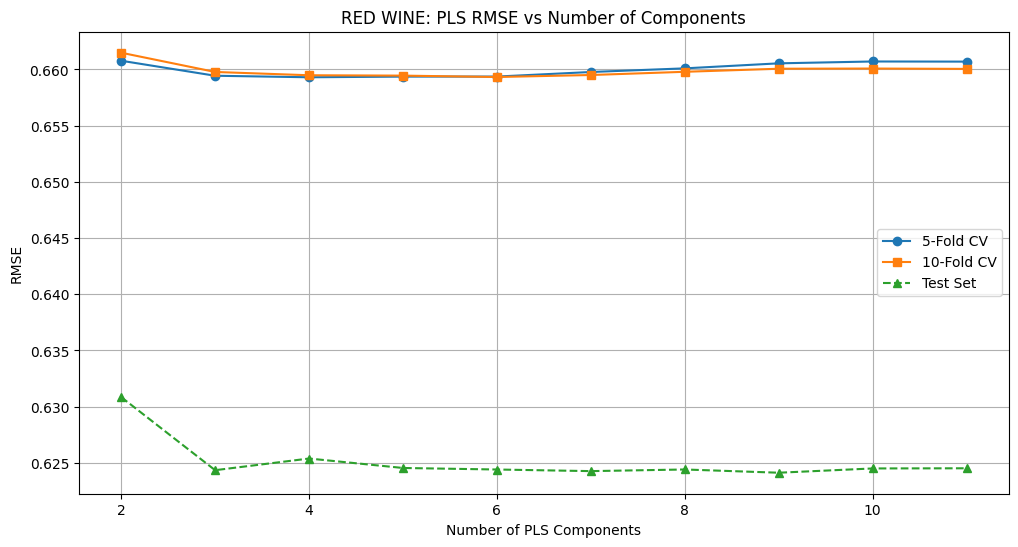

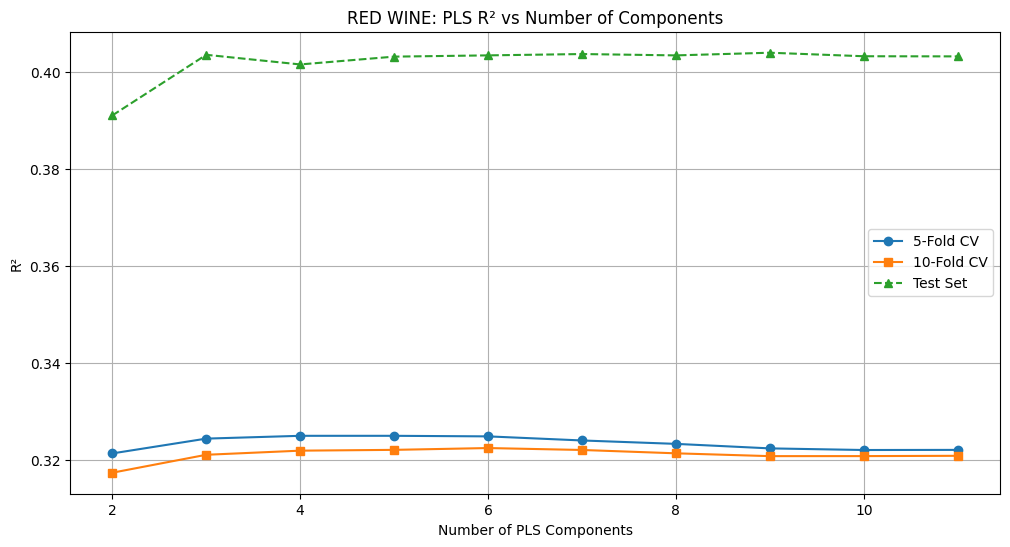

In [33]:
print("################################################")
print("##### PLS - RED WINE (Implementação Manual) #####")
print("################################################")

X_red = df_red.drop(['quality'], axis=1)
y_red = df_red['quality']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

RMSE_per_component_5fold_red = []
RMSE_per_component_10fold_red = []
R2_per_component_5fold_red = []
R2_per_component_10fold_red = []
RMSE_test_per_component_red = []
R2_test_per_component_red = []

for i in range(2, 12):
    print(f"\nNumber of PLS Components: {i}")
    k_fold_results_5 = k_fold_pls(X_train_red, y_train_red, k=5, n_comp=i)
    k_fold_results_10 = k_fold_pls(X_train_red, y_train_red, k=10, n_comp=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold_red.append(k_fold_results_5[2])
    R2_per_component_5fold_red.append(k_fold_results_5[4])
    RMSE_per_component_10fold_red.append(k_fold_results_10[2])
    R2_per_component_10fold_red.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    model = fit_pls_manual(X_train_red, y_train_red, n_components=i)
    y_test_pred = predict_pls_manual(model, X_test_red)
    
    test_rmse = np.sqrt(np.mean((y_test_red - y_test_pred)**2))
    ss_res_test = np.sum((y_test_red - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_red - y_test_red.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component_red.append(test_rmse)
    R2_test_per_component_red.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold_red)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold_red)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold_red[optimal_5fold_idx]:.4f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold_red[optimal_10fold_idx]:.4f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component_red[optimal_5fold_idx]:.4f}")
print(f"Test Set R²: {R2_test_per_component_red[optimal_5fold_idx]:.4f}")
print("="*60)

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold_red, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold_red, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component_red, marker='^', label='Test Set', linestyle='--')
plt.title('RED WINE: PLS RMSE vs Number of Components')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold_red, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold_red, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component_red, marker='^', label='Test Set', linestyle='--')
plt.title('RED WINE: PLS R² vs Number of Components')
plt.xlabel('Number of PLS Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()



################################################
##### PLS - WHITE WINE (Implementação Manual) ###
################################################

Number of PLS Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7719', '0.7455', '0.7561', '0.7997', '0.7633']
R² per fold  : ['0.2304', '0.2482', '0.2477', '0.2272', '0.2937']

RMSE Mean ± Std: 0.7673 ± 0.0184
R²   Mean ± Std: 0.2494 ± 0.0237


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7387', '0.7996', '0.7285', '0.7587', '0.7474', '0.7664', '0.7598', '0.8356', '0.7872', '0.7380']
R² per fold  : ['0.2609', '0.2095', '0.2463', '0.2562', '0.2338', '0.2637', '0.2581', '0.2006', '0.2387', '0.3462']

RMSE Mean ± Std: 0.7660 ± 0.0313
R²   Mean ± Std: 0.2514 ± 0.0376


Number of PLS Components: 3

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.7417', '0.7369', '0.7569', '0.7911', '0.7557']
R² per fold  : ['0.2895', '0.2653', '0.2461', '0.2438', '0.3077']

RMSE Mean ± Std: 0.7565 ± 0.0190
R²   Mea

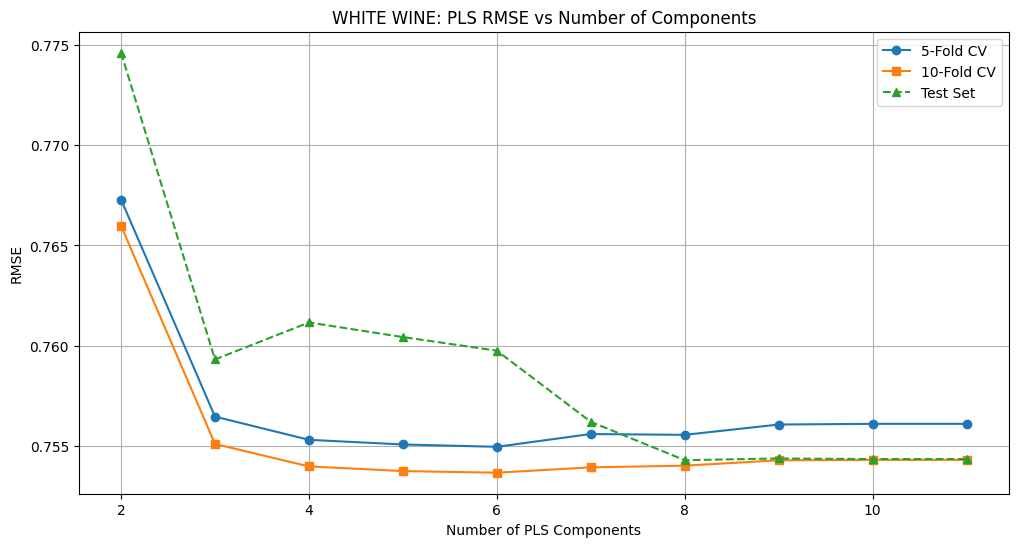

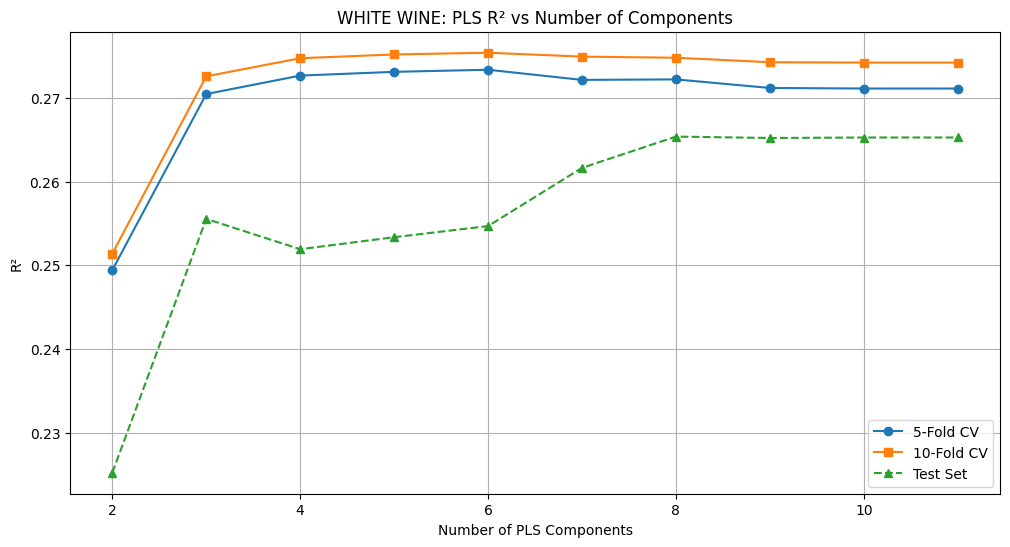

In [34]:
print("\n\n################################################")
print("##### PLS - WHITE WINE (Implementação Manual) ###")
print("################################################")

X_white = df_white.drop(['quality'], axis=1)
y_white = df_white['quality']
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white, y_white, test_size=0.2, random_state=42)

RMSE_per_component_5fold_white = []
RMSE_per_component_10fold_white = []
R2_per_component_5fold_white = []
R2_per_component_10fold_white = []
RMSE_test_per_component_white = []
R2_test_per_component_white = []

for i in range(2, 12):
    print(f"\nNumber of PLS Components: {i}")
    k_fold_results_5 = k_fold_pls(X_train_white, y_train_white, k=5, n_comp=i)
    k_fold_results_10 = k_fold_pls(X_train_white, y_train_white, k=10, n_comp=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold_white.append(k_fold_results_5[2])
    R2_per_component_5fold_white.append(k_fold_results_5[4])
    RMSE_per_component_10fold_white.append(k_fold_results_10[2])
    R2_per_component_10fold_white.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    model = fit_pls_manual(X_train_white, y_train_white, n_components=i)
    y_test_pred = predict_pls_manual(model, X_test_white)
    
    test_rmse = np.sqrt(np.mean((y_test_white - y_test_pred)**2))
    ss_res_test = np.sum((y_test_white - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_white - y_test_white.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component_white.append(test_rmse)
    R2_test_per_component_white.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold_white)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold_white)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold_white[optimal_5fold_idx]:.4f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold_white[optimal_10fold_idx]:.4f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component_white[optimal_5fold_idx]:.4f}")
print(f"Test Set R²: {R2_test_per_component_white[optimal_5fold_idx]:.4f}")
print("="*60)

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold_white, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold_white, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component_white, marker='^', label='Test Set', linestyle='--')
plt.title('WHITE WINE: PLS RMSE vs Number of Components')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold_white, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold_white, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component_white, marker='^', label='Test Set', linestyle='--')
plt.title('WHITE WINE: PLS R² vs Number of Components')
plt.xlabel('Number of PLS Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()

COMBINED RED + WHITE WINE


In [35]:
df_combined = pd.concat([df_red, df_white], ignore_index=True)
df_combined


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


PCR - Combined Dataset


In [49]:
X_combined = df_combined.drop(['citric acid'], axis=1)
y_combined = df_combined['citric acid']
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

RMSE_per_component_5fold = []
RMSE_per_component_10fold=[]
R2_per_component_5fold = []
R2_per_component_10fold=[]
RMSE_test_per_component = []
R2_test_per_component = []

# Preprocess training and test sets once
X_train_mean = X_train_combined.mean(axis=0)
X_train_std = X_train_combined.std(axis=0)
X_train_std[X_train_std == 0] = 1

X_train_scaled = (X_train_combined - X_train_mean) / X_train_std
X_test_scaled = (X_test_combined - X_train_mean) / X_train_std

cov_train = np.cov(X_train_scaled, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_train)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

for i in range(2,12):
    print("\nNumber of Principal Components:", i)
    k_fold_results_5 = k_fold_pcr(X_train_combined, y_train_combined, k=5, n_components=i)
    k_fold_results_10 = k_fold_pcr(X_train_combined, y_train_combined, k=10, n_components=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold.append(k_fold_results_5[2])
    R2_per_component_5fold.append(k_fold_results_5[4])
    RMSE_per_component_10fold.append(k_fold_results_10[2])
    R2_per_component_10fold.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    V = eigenvectors[:, :i]
    X_train_pca = X_train_scaled @ V
    X_test_pca = X_test_scaled @ V
    
    X_train_adjusted = np.hstack([np.ones((X_train_pca.shape[0], 1)), X_train_pca])
    X_test_adjusted = np.hstack([np.ones((X_test_pca.shape[0], 1)), X_test_pca])
    
    beta = np.linalg.inv(X_train_adjusted.T @ X_train_adjusted) @ X_train_adjusted.T @ y_train_combined
    y_test_pred = X_test_adjusted @ beta
    
    test_rmse = np.sqrt(np.mean((y_test_combined - y_test_pred)**2))
    ss_res_test = np.sum((y_test_combined - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_combined - y_test_combined.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component.append(test_rmse)
    R2_test_per_component.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold[optimal_5fold_idx]:.17f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold[optimal_10fold_idx]:.17f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component[optimal_5fold_idx]:.17f}")
print(f"Test Set R²: {R2_test_per_component[optimal_5fold_idx]:.17f}")
print("="*60)



Number of Principal Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.14513406376667087', '0.14154577629758541', '0.13902410016613020', '0.14299507175083134', '0.14092078226756466']
R² per fold  : ['0.04364086967009584', '0.03435700277388398', '0.03647100333554820', '0.05482808974488595', '0.01094743246298202']

RMSE Mean ± Std: 0.14192395884975650 ± 0.00204990839343003
R²   Mean ± Std: 0.03604887959747920 ± 0.01444590136270902


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.14804072380358682', '0.14212884774992773', '0.14118123257106596', '0.14213227063915407', '0.14010633304012166', '0.13804923586761048', '0.13759789453977250', '0.14790771800916533', '0.13692440669218137', '0.14457245213806655']
R² per fold  : ['0.04309232177447364', '0.04473670533076446', '0.02742417069167624', '0.03365404486644452', '0.02882342766349044', '0.04343049266062471', '0.03174941530524078', '0.07373892357261724', '-0.01281531142263304', '0.03498141295698998']

RMSE Mean 

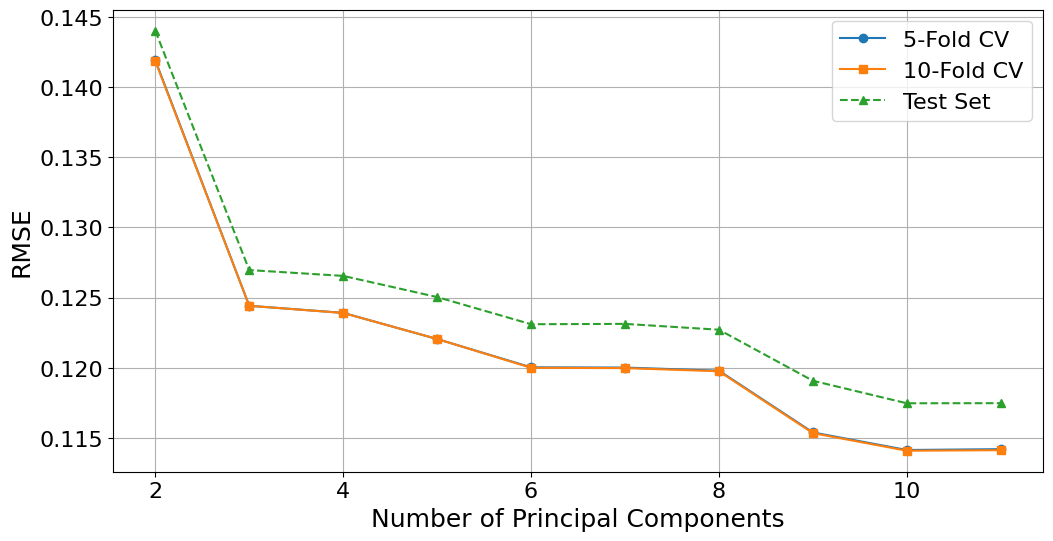

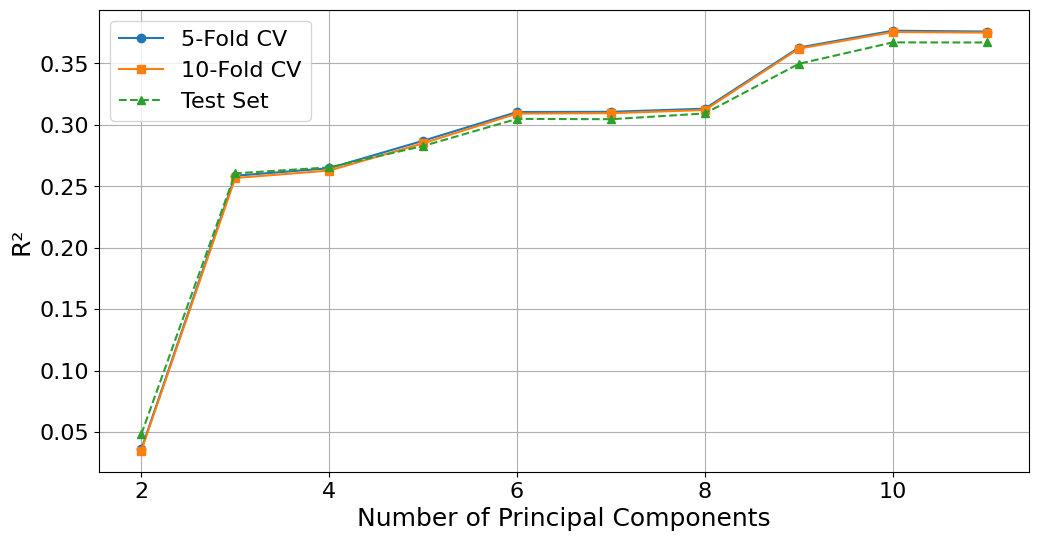

In [ ]:
# Aumenta o tamanho da fonte global dos gráficos
plt.rcParams.update({
    'font.size': 16,        # tamanho geral da fonte
    'axes.titlesize': 18,   # tamanho do título dos eixos
    'axes.labelsize': 18,   # tamanho dos labels (xlabel, ylabel)
    'xtick.labelsize': 16,  # tamanho dos ticks do eixo x
    'ytick.labelsize': 16,  # tamanho dos ticks do eixo y
    'legend.fontsize': 16,  # tamanho da legenda
})

# ---------- RMSE ----------
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component, marker='^', label='Test Set', linestyle='--')

plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

# ---------- R² ----------
plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component, marker='^', label='Test Set', linestyle='--')

plt.xlabel('Number of Principal Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()


PLS - Combined Dataset


In [51]:
print("################################################")
print("##### PLS - COMBINED DATASET (Red + White) #####")
print("################################################")

X_combined = df_combined.drop(['citric acid'], axis=1)
y_combined = df_combined['citric acid']
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

RMSE_per_component_5fold_combined = []
RMSE_per_component_10fold_combined = []
R2_per_component_5fold_combined = []
R2_per_component_10fold_combined = []
RMSE_test_per_component_combined = []
R2_test_per_component_combined = []

for i in range(2, 12):
    print(f"\nNumber of PLS Components: {i}")
    k_fold_results_5 = k_fold_pls(X_train_combined, y_train_combined, k=5, n_comp=i)
    k_fold_results_10 = k_fold_pls(X_train_combined, y_train_combined, k=10, n_comp=i)
    print_cv_results("5-FOLD CROSS VALIDATION", k_fold_results_5)
    print_cv_results("10-FOLD CROSS VALIDATION", k_fold_results_10)
    RMSE_per_component_5fold_combined.append(k_fold_results_5[2])
    R2_per_component_5fold_combined.append(k_fold_results_5[4])
    RMSE_per_component_10fold_combined.append(k_fold_results_10[2])
    R2_per_component_10fold_combined.append(k_fold_results_10[4])
    
    # Evaluate on test set for this number of components
    model = fit_pls_manual(X_train_combined, y_train_combined, n_components=i)
    y_test_pred = predict_pls_manual(model, X_test_combined)
    
    test_rmse = np.sqrt(np.mean((y_test_combined - y_test_pred)**2))
    ss_res_test = np.sum((y_test_combined - y_test_pred)**2)
    ss_tot_test = np.sum((y_test_combined - y_test_combined.mean())**2)
    test_r2 = 1 - (ss_res_test / ss_tot_test)
    
    RMSE_test_per_component_combined.append(test_rmse)
    R2_test_per_component_combined.append(test_r2)

optimal_5fold_idx = np.argmin(RMSE_per_component_5fold_combined)
optimal_10fold_idx = np.argmin(RMSE_per_component_10fold_combined)
optimal_5fold_ncomp = optimal_5fold_idx + 2
optimal_10fold_ncomp = optimal_10fold_idx + 2

print("\n" + "="*60)
print("OPTIMAL NUMBER OF COMPONENTS:")
print(f"5-Fold CV: {optimal_5fold_ncomp} components (RMSE: {RMSE_per_component_5fold_combined[optimal_5fold_idx]:.17f})")
print(f"10-Fold CV: {optimal_10fold_ncomp} components (RMSE: {RMSE_per_component_10fold_combined[optimal_10fold_idx]:.17f})")
print("="*60)

print("\n" + "="*60)
print("TEST SET EVALUATION (using optimal from 5-fold CV):")
print("="*60)
print(f"\nTest Set RMSE: {RMSE_test_per_component_combined[optimal_5fold_idx]:.17f}")
print(f"Test Set R²: {R2_test_per_component_combined[optimal_5fold_idx]:.17f}")
print("="*60)


################################################
##### PLS - COMBINED DATASET (Red + White) #####
################################################

Number of PLS Components: 2

====== 5-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.11692118708484235', '0.11589085267478838', '0.11438072749665223', '0.12084073280039136', '0.11639338084512024']
R² per fold  : ['0.37931860283248886', '0.35267693382505849', '0.34778570646924856', '0.32501306492980375', '0.32527647836238627']

RMSE Mean ± Std: 0.11688537618035891 ± 0.00215176810341342
R²   Mean ± Std: 0.34601415728379720 ± 0.02013859120281017


====== 10-FOLD CROSS VALIDATION ======
RMSE per fold: ['0.12225729785973756', '0.11131401209071684', '0.11191585510753264', '0.11974293704591887', '0.11661208992801041', '0.11226815180322752', '0.11657465283271029', '0.12466634724308115', '0.11502635864064897', '0.11822810345796818']
R² per fold  : ['0.34738473897122479', '0.41405305695084005', '0.38884303073222137', '0.31412170851374854', '0.327225

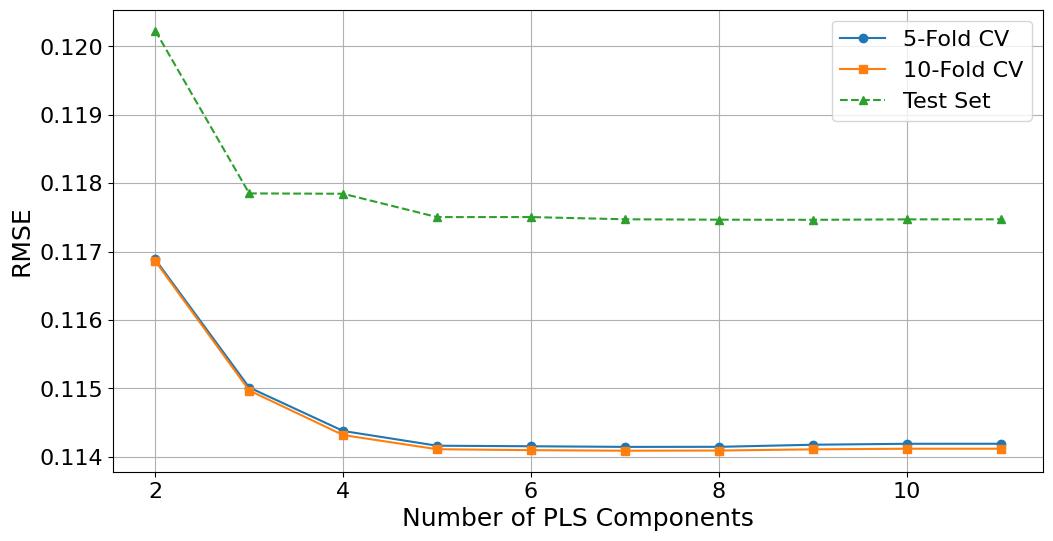

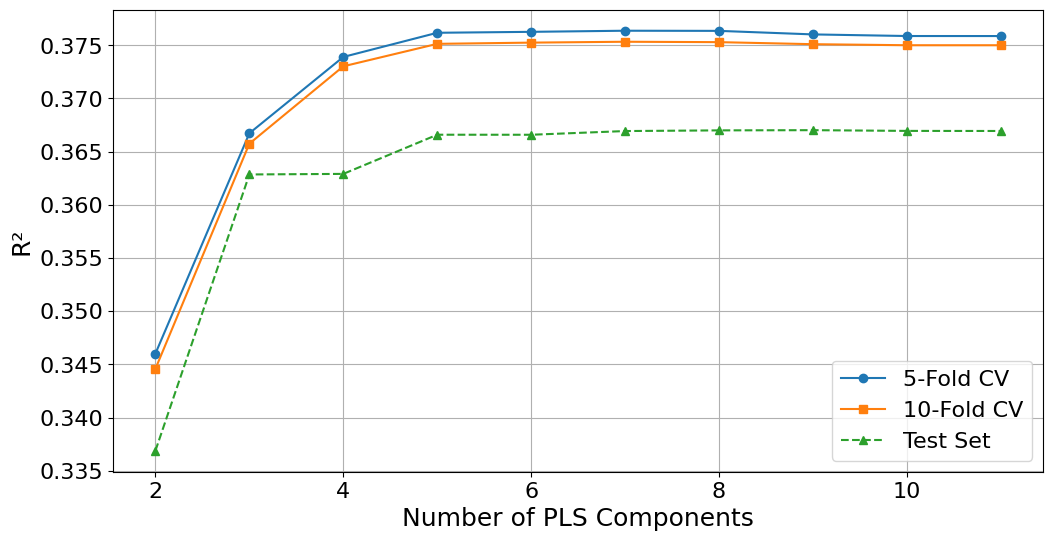

In [54]:
plt.rcParams.update({
    'font.size': 16,        # tamanho geral da fonte
    'axes.titlesize': 18,   # tamanho do título dos eixos
    'axes.labelsize': 18,   # tamanho dos labels (xlabel, ylabel)
    'xtick.labelsize': 16,  # tamanho dos ticks do eixo x
    'ytick.labelsize': 16,  # tamanho dos ticks do eixo y
    'legend.fontsize': 16,  # tamanho da legenda
})


plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), RMSE_per_component_5fold_combined, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), RMSE_per_component_10fold_combined, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), RMSE_test_per_component_combined, marker='^', label='Test Set', linestyle='--')
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(2, 12), R2_per_component_5fold_combined, marker='o', label='5-Fold CV')
plt.plot(range(2, 12), R2_per_component_10fold_combined, marker='s', label='10-Fold CV')
plt.plot(range(2, 12), R2_test_per_component_combined, marker='^', label='Test Set', linestyle='--')
plt.xlabel('Number of PLS Components')
plt.ylabel('R²')
plt.legend()
plt.grid()
plt.show()
